## GRID Model implementation

## Imports and setup

In [ ]:
!apt-get -y install libopenjp2-7-dev libopenjp2-tools openslide-tools | tail --line 1
!pip install tiatoolbox seaborn | tail -n 1
ON_GPU=False
print('Installation is done.')
!pip install torch==1.9.1+cu102 torchvision==0.10.1+cu102 -f https://download.pytorch.org/whl/cu102/torch_stable.html --user
ON_GPU = True 
!pip install seaborn
!pip install Pillow==9.0.0
!pip install validators matplotlib
!pip install torch-summary
!pip uninstall matplotlib
!pip install matplotlib==3.1.3
!pip install captum
!pip install segmentation_models_pytorch
!pip install torchmetrics

Processing triggers for man-db (2.8.3-2ubuntu0.1) ...


Installation is done.
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in links: https://download.pytorch.org/whl/cu102/torch_stable.html
     |████████████████████████████████| 831.4 MB 6.7 kB/s 
     |████████████████████████████████| 22.1 MB 40 kB/s 
  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
torchtext 0.13.1 requires torch==1.12.1, but you have torch 1.9.1+cu102 which is incompatible.
torchaudio 0.12.1+cu113 requires torch==1.12.1, but you have torch 1.9.1+cu102 which is incompatible.
tiatoolbox 1.2.1 requires torch>=1.11.0, but you have torch 1.9.1+cu102 which is incompatible.
tiatoolbox 1.2.1 requires torchvision>=0.12.0, but you have torchvision 0.10.1+cu102 which is incompatibl

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Created wheel for validators: filename=validators-0.20.0-py3-none-any.whl size=19582 sha256=3c9dac62059a4d1b8ab88e64b0edba70057e963bcc3644eb7fb17a8302e43393
  Stored in directory: /root/.cache/pip/wheels/5f/55/ab/36a76989f7f88d9ca7b1f68da6d94252bb6a8d6ad4f18e04e9
Successfully built validators
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Found existing installation: matplotlib 3.5.3
Uninstalling matplotlib-3.5.3:
  Would remove:
    /usr/local/lib/python3.7/dist-packages/matplotlib-3.5.3-py3.7-nspkg.pth
    /usr/local/lib/python3.7/dist-packages/matplotlib-3.5.3.dist-info/*
    /usr/local/lib/python3.7/dist-packages/matplotlib/*
    /usr/local/lib/python3.7/dist-packages/mpl_toolkits/axes_grid/*
    /usr/local/lib/python3.7/dist-packages/mpl_toolkits/axes_grid1/*
    /usr/local/lib/python3.7/dist-packages/mpl_toolkits/axisartist/*
   

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 1.4 MB 4.3 MB/s 
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 97 kB 3.4 MB/s 
     |████████████████████████████████| 376 kB 23.6 MB/s 
     |████████████████████████████████| 58 kB 6.3 MB/s 
  Created wheel for efficientnet-pytorch: filename=efficientnet_pytorch-0.7.1-py3-none-any.whl size=16446 sha256=7c3b705cdcb525482aea74fe084df45a969a9695a8f70b0c694041b2b01e9b78
  Stored in directory: /root/.cache/pip/wheels/0e/cc/b2/49e74588263573ff778da58cc99b9c6349b496636a7e165be6
  Created wheel for pretrainedmodels: filename=pretrainedmodels-0.7.4-py3-none-any.whl size=60965 sha256=5c67aa8532d12fcb556de1d42b0a642772ab4906221105e187e7d380c15829b5
  Stored in directory: /root/.cache/pip/wheels/ed/27/e8/9543d42de2740d3544db96aefef63bda3f2c1761b3334f4873
Successfully 

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
import tables
import cv2
from PIL import Image
from random import randint 
import torchvision
import tables as pt
import torch
import torch.nn as nn
import torchvision.transforms as transforms
import torchvision.transforms.functional as F
import torch.nn.functional as P
import random
import albumentations as A
import sys
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt 
from skimage import segmentation

import numpy as np
from tiatoolbox.tools import patchextraction
import time
import os
import copy
from sklearn.metrics import cohen_kappa_score,precision_score, recall_score, f1_score, multilabel_confusion_matrix, confusion_matrix
import pandas as pd
from sklearn.model_selection import train_test_split
import seaborn as sns 
import warnings
warnings.filterwarnings('ignore')
import pickle
import PIL 
from torchsummary import summary
from captum.attr import IntegratedGradients
from captum.attr import GradientShap
from tiatoolbox.models.engine.semantic_segmentor import (
    IOSegmentorConfig,
    SemanticSegmentor,
)
import math
from tqdm import tqdm
from torchmetrics import JaccardIndex
from captum.attr import Occlusion
from captum.attr import NoiseTunnel
from captum.attr import visualization as viz
from matplotlib.colors import LinearSegmentedColormap
from google.colab.patches import cv2_imshow
from skimage.morphology import reconstruction
from tiatoolbox.tools.tissuemask import MorphologicalMasker
plt.style.use('seaborn')
import segmentation_models_pytorch as smp
from segmentation_models_pytorch.encoders import get_preprocessing_fn
from torchvision.transforms.transforms import ToPILImage
from albumentations.pytorch.transforms import ToTensorV2
from skimage import segmentation

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [ ]:
img_dtype = tables.UInt8Atom()  # dtype in which the images will be saved, this indicates that images will be saved as unsigned int 8 bit, i.e., [0,255]
filenameAtom = tables.StringAtom(itemsize=255) #create an atom to store the filename of the image, just incase we need it later, 
training_directory = '/content/gdrive/MyDrive/1.training/1.training/'
validation_directory = '/content/gdrive/MyDrive/2.validation/2.validation/'
testing_directory = '/content/gdrive/MyDrive/3.testing/3.testing/'


In [ ]:
#Match the ground truth to the training image
X_image_strings = list()
training_y = list()

for image_string in os.listdir(training_directory):
  X_image_strings.append(os.path.join(training_directory,image_string))
  new_string = image_string[-13:-4].strip()
  new_label= [int(new_string[-8]),int(new_string[-5]),int(new_string[-2])]
  training_y.append(np.array(new_label))

In [ ]:
non_single_class_images = list()
non_single_class_images_y = list()
only_tumour_i = list()
only_stroma_i = list()
only_normal_i = list()
listing_dir = os.listdir(training_directory)
for i in range(len(listing_dir)):
   io=cv2.cvtColor(cv2.imread(training_directory+listing_dir[i]),cv2.COLOR_BGR2RGB)
   interp_method=PIL.Image.BICUBIC
   io = cv2.resize(io,(0,0),fx=1,fy=1, interpolation=interp_method) #resize it as specified above
   io = cv2.resize(io,(224,224))

   if all(training_y[i] == [1,0,0]):
      only_tumour_i.append(io)
   elif all(training_y[i] == [0,1,0]):
      only_stroma_i.append(io)
   elif all(training_y[i] == [0,0,1]):
      only_normal_i.append(io)
   else:
     non_single_class_images.append(io)
     non_single_class_images_y.append(training_y[i])



In [ ]:
def create_background_mask(image):
  background_map =  np.zeros((224,224),dtype=np.uint8)
  kernel = np.ones((3,3),np.uint8)
  for i in range(224):
    for j in range(224):
      if all(pixel>= 224 for pixel in image[i][j]):
        background_map[i][j] = 255
      else:
        background_map[i][j] = 0
  closing = cv2.morphologyEx(background_map, cv2.MORPH_CLOSE, kernel)
  final = cv2.erode(closing,kernel,iterations = 1)

  return final 

In [ ]:
def make_mask_tumour(image):
  bg_mask = create_background_mask(image)
  image_mask = np.zeros((224,224,3),dtype=np.uint8)
  for i in range(len(bg_mask)):
    for j in range(len(bg_mask[i])):
      if (bg_mask[i][j]==255).all():
        image_mask[i][j] = [255,255,255]
      else:
        image_mask[i][j] = [0,64,128]
  return image_mask

In [ ]:
def make_mask_stroma(image):
  bg_mask = create_background_mask(image)
  image_mask = np.zeros((224,224,3),dtype=np.uint8)

  for i in range(len(bg_mask)):
    for j in range(len(bg_mask[i])):
      if (bg_mask[i][j]==255).all():
        image_mask[i][j] = [255,255,255]
      else:
        image_mask[i][j] = [64,128,0]
  return image_mask

In [ ]:
def make_mask_normal(image):
  bg_mask = create_background_mask(image)
  image_mask = np.zeros((224,224,3),dtype=np.uint8)
  for i in range(len(bg_mask)):
    for j in range(len(bg_mask[i])):
      if (bg_mask[i][j]==255).all():
        image_mask[i][j] = [255,255,255]
      else:
        image_mask[i][j] = [243,152,0]
  return image_mask

In [ ]:
def create_images_for_item(all_data,class_name):
  Masks = list()
  if class_name == 'tumour':
    for item in all_data:
      Masks.append(make_mask_tumour(item))
  elif class_name == 'stroma':
    for item in all_data:
      Masks.append(make_mask_stroma(item))
  elif class_name == 'normal':
    for item in all_data:
      Masks.append(make_mask_normal(item))
  return Masks

([], <a list of 0 Text yticklabel objects>)

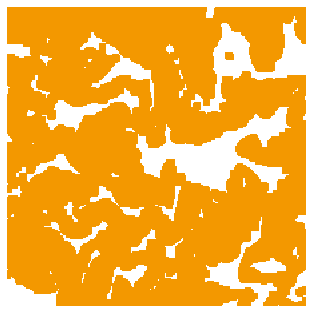

In [ ]:
plt.imshow(make_mask_normal(only_normal_i[0]))
plt.grid(False)
plt.xticks([])
plt.yticks([])


([], <a list of 0 Text yticklabel objects>)

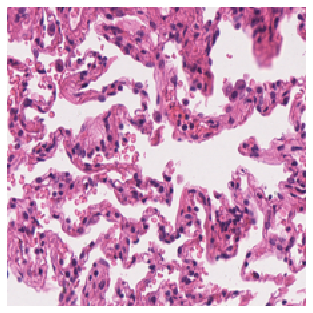

In [ ]:
plt.imshow(only_normal_i[0])
plt.grid(False)
plt.xticks([])
plt.yticks([])


In [ ]:
tumour_masks = create_images_for_item(only_tumour_i,'tumour')

In [ ]:
stroma_masks = create_images_for_item(only_stroma_i,'stroma')

In [ ]:
normal_masks = create_images_for_item(only_normal_i,'normal')

In [ ]:
for i in range(len(only_tumour_i)):
  number = str(i)
  with open('/content/gdrive/MyDrive/Whole_masks/images/tumour/'+number+'.npy', 'wb') as f:
      np.save(f, only_tumour_i[i])

  with open('/content/gdrive/MyDrive/Whole_masks/masks/tumour/'+number+'.npy', 'wb') as f:
      np.save(f, tumour_masks[i])

for i in range(len(only_stroma_i)):
  number = str(i)
  with open('/content/gdrive/MyDrive/Whole_masks/images/stroma/'+number+'.npy', 'wb') as f:
      np.save(f, only_stroma_i[i])

  with open('/content/gdrive/MyDrive/Whole_masks/masks/stroma/'+number+'.npy', 'wb') as f:
      np.save(f, stroma_masks[i])

for i in range(len(only_normal_i)):
  number = str(i)
  with open('/content/gdrive/MyDrive/Whole_masks/images/normal/'+number+'.npy', 'wb') as f:
      np.save(f, only_normal_i[i])

  with open('/content/gdrive/MyDrive/Whole_masks/masks/normal/'+number+'.npy', 'wb') as f:
      np.save(f, normal_masks[i])

In [ ]:
tumour_masks = list()
stroma_masks = list()
normal_masks = list()
for i in range(len(only_tumour_i)):
  number = str(i)
  tumour_masks.append(np.load('/content/gdrive/MyDrive/Whole_masks/masks/tumour/'+number+'.npy',))

for i in range(len(only_stroma_i)):
  number = str(i)
  stroma_masks.append(np.load('/content/gdrive/MyDrive/Whole_masks/masks/stroma/'+number+'.npy',))


for i in range(len(only_normal_i)):
  number = str(i)
  normal_masks.append(np.load('/content/gdrive/MyDrive/Whole_masks/masks/normal/'+number+'.npy',))
  



## Patch_creation 

In [ ]:
def create_a_tiled_image(image,mask):
  total_image_grid = list()
  row_image = list()
  total_mask_grid = list()
  row_mask = list()


  count_image = 0
  count_mask = 0
  sliding_window_patch_extractor = patchextraction.SlidingWindowPatchExtractor(
          input_img=image, # input image path, numpy array, or WSI object
          patch_size=(32, 32),
          input_mask = None,
          # also supports "point" and "slidingwindow"
          # size of the patch to extract around the centroids from centroids_list
      )
  
  sliding_window_patch_extractor_mask = patchextraction.SlidingWindowPatchExtractor(
          input_img=mask, # input image path, numpy array, or WSI object
          patch_size=(32, 32),
          input_mask = None,
          # also supports "point" and "slidingwindow"
          # size of the patch to extract around the centroids from centroids_list
          # stride of extracting patches, default is equal to patch_size
      )
  
  for patch in sliding_window_patch_extractor:
    row_image.append(patch)
    if len(row_image) == 7:
      total_image_grid.append(row_image)
      row_image = list()

  for patch in sliding_window_patch_extractor_mask:
    row_mask.append(patch)
    if len(row_mask) == 7:
      total_mask_grid.append(row_mask)
      row_mask = list()
  return total_image_grid, total_mask_grid



In [ ]:
def create_random_triple_map():
  map = []
  for y in range(7):
      row = []
      for x in range(7):
          row.append(random.randint(1, 3))
      map.append(row)
  return map



In [ ]:
print(create_random_triple_map())

[[2, 1, 1, 3, 3, 3, 2], [1, 3, 1, 3, 1, 1, 3], [3, 1, 3, 2, 1, 2, 3], [2, 3, 2, 1, 3, 3, 2], [2, 3, 1, 3, 1, 1, 3], [2, 2, 1, 2, 3, 3, 3], [3, 3, 2, 2, 2, 3, 3]]


In [ ]:
tumour_image_grids = list()
tumour_mask_grids = list()

stroma_image_grids = list()
stroma_mask_grids = list()

normal_image_grids = list()
normal_mask_grids = list()

for i in range(len(only_tumour_i)):
  image_grid, mask_grid = create_a_tiled_image(only_tumour_i[i], tumour_masks[i])

  tumour_image_grids.append(image_grid)
  tumour_mask_grids.append(mask_grid)

for i in range(len(only_stroma_i)):
  image_grid, mask_grid = create_a_tiled_image(only_stroma_i[i], stroma_masks[i])
  stroma_image_grids.append(image_grid)
  stroma_mask_grids.append(mask_grid)


for i in range(len(only_normal_i)):
  image_grid, mask_grid = create_a_tiled_image(only_normal_i[i], normal_masks[i])

  normal_image_grids.append(image_grid)
  normal_mask_grids.append(mask_grid)


In [ ]:
len(normal_mask_grids)

1832

In [ ]:
len(tumour_image_grids[0][0])

4

In [ ]:
def create_triple_class_image(tumour_grid, stroma_grid, normal_grid, tumour_mask_grid, stroma_mask_grid, normal_mask_grid):
  prob_grid = create_random_triple_map()
  image = np.zeros((224,224,3),dtype=np.uint8)
  mask = np.zeros((224,224,3),dtype=np.uint8)
  print(prob_grid)

  for i in range(1,8):
    for j in range(1,8):
      if prob_grid[i-1][j-1] == 1:
        image[(i-1)*32 : i*32, (j-1)*32 : j*32, :] = tumour_grid[i-1][j-1]
        mask[(i-1)*32 : i*32, (j-1)*32 : j*32, :] = tumour_mask_grid[i-1][j-1]
      elif prob_grid[i-1][j-1] == 2:
        image[(i-1)*32:i*32,(j-1)*32:j*32,:] = stroma_grid[i-1][j-1]
        mask[(i-1)*32 : i*32, (j-1)*32 : j*32, :] = stroma_mask_grid[i-1][j-1]

      elif prob_grid[i-1][j-1] == 3:
        image[(i-1)*32:i*32,(j-1)*32:j*32,:] = normal_grid[i-1][j-1]
        mask[(i-1)*32 : i*32, (j-1)*32 : j*32, :] = normal_mask_grid[i-1][j-1]

  spare_images = {
      'tumour': list(),
      'stroma': list(),
      'normal': list()
  }
  spare_image_masks = {
      'tumour':list(),
      'stroma':list(),
      'normal':list()
  }

  for i in range(0,7):
    for j in range(0,7):
      if prob_grid[i][j] == 1:
        spare_images['stroma'].append(stroma_grid[i][j])
        spare_images['normal'].append(normal_grid[i][j])

        spare_image_masks['stroma'].append(stroma_mask_grid[i][j])
        spare_image_masks['normal'].append(normal_mask_grid[i][j])
      elif prob_grid[i][j] == 2:
        spare_images['tumour'].append(tumour_grid[i][j])
        spare_images['normal'].append(normal_grid[i][j])

        spare_image_masks['tumour'].append(tumour_mask_grid[i][j])
        spare_image_masks['normal'].append(normal_mask_grid[i][j])
      elif prob_grid[i][j] == 3:
        spare_images['stroma'].append(stroma_grid[i][j])
        spare_images['normal'].append(normal_grid[i][j])

        spare_image_masks['stroma'].append(stroma_mask_grid[i][j])
        spare_image_masks['normal'].append(normal_mask_grid[i][j])

  return image, mask, prob_grid, spare_images, spare_image_masks

  


    


In [ ]:
plt.imshow(tumour_image_grids[0][0]])

SyntaxError: ignored

In [ ]:
image, mask, prob_grid, spare_images, spare_image_masks = create_triple_class_image(tumour_image_grids[0], stroma_image_grids[0], normal_image_grids[0], tumour_mask_grids[0], stroma_mask_grids[0], normal_mask_grids[0])

[[3, 3, 2, 2, 2, 3, 1], [3, 3, 2, 2, 2, 1, 1], [2, 1, 2, 1, 2, 1, 2], [2, 2, 2, 3, 1, 3, 3], [1, 3, 1, 2, 2, 2, 1], [3, 1, 1, 3, 2, 1, 1], [1, 3, 1, 3, 1, 1, 2]]


([], <a list of 0 Text yticklabel objects>)

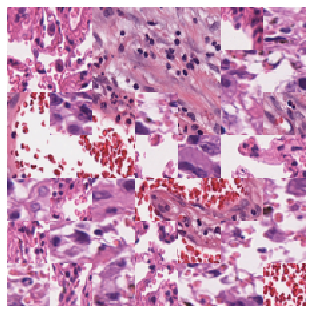

In [ ]:
plt.imshow(image)
plt.grid(False)
plt.xticks([])
plt.yticks([])

([], <a list of 0 Text yticklabel objects>)

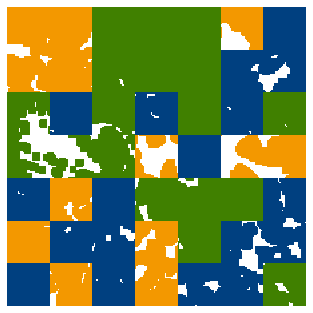

In [ ]:
plt.imshow(mask)
plt.grid(False)
plt.xticks([])
plt.yticks([])

In [ ]:
prob_grid

[[1, 3, 3, 2], [2, 2, 3, 1], [2, 3, 2, 2], [1, 1, 1, 2]]

In [ ]:
triple_images = list()
triple_image_masks = list()
spare_images_triple = list()
spare_image_masks_triple = list()
prob_grids = list()

for i in range(400):
  image, mask, grid, spare_images_dict, spare_mask_dict = create_triple_class_image(tumour_image_grids[i],stroma_image_grids[i],normal_image_grids[i], tumour_mask_grids[i], stroma_mask_grids[i], normal_mask_grids[i])
  triple_images.append(image)
  triple_image_masks.append(mask)
  prob_grids.append(grid)
  spare_images_triple.append(spare_images_dict)
  spare_image_masks_triple.append(spare_mask_dict)


[[2, 2, 1, 3, 3, 2, 2], [1, 2, 2, 3, 1, 1, 1], [1, 1, 2, 2, 2, 3, 2], [2, 1, 2, 1, 2, 2, 2], [3, 2, 1, 2, 2, 1, 1], [1, 3, 2, 1, 2, 3, 3], [1, 3, 2, 3, 2, 1, 2]]
[[1, 3, 2, 3, 1, 3, 1], [1, 3, 2, 2, 3, 3, 2], [2, 3, 3, 3, 2, 3, 2], [3, 3, 2, 3, 3, 2, 1], [3, 2, 2, 1, 2, 2, 2], [2, 2, 2, 1, 3, 2, 1], [3, 1, 3, 3, 2, 2, 1]]
[[1, 3, 3, 2, 1, 1, 2], [3, 2, 3, 1, 3, 1, 1], [1, 3, 1, 3, 1, 3, 3], [1, 1, 1, 3, 2, 3, 3], [3, 1, 2, 2, 3, 2, 1], [1, 3, 1, 3, 1, 3, 2], [2, 1, 2, 3, 3, 1, 1]]
[[3, 3, 2, 3, 2, 3, 1], [1, 3, 1, 1, 1, 2, 2], [3, 2, 1, 2, 1, 3, 2], [1, 3, 1, 1, 2, 1, 2], [1, 3, 3, 2, 3, 2, 2], [1, 1, 3, 3, 3, 1, 2], [1, 2, 3, 1, 1, 3, 2]]
[[3, 3, 3, 3, 2, 2, 1], [3, 3, 1, 3, 2, 2, 1], [3, 2, 3, 3, 3, 1, 1], [3, 3, 1, 2, 1, 1, 2], [2, 2, 2, 3, 2, 3, 3], [1, 1, 3, 3, 1, 1, 1], [1, 1, 3, 1, 1, 3, 1]]
[[1, 1, 3, 2, 3, 3, 1], [1, 3, 3, 1, 3, 1, 1], [3, 2, 2, 2, 3, 3, 2], [3, 2, 2, 3, 3, 2, 1], [1, 3, 3, 3, 3, 3, 2], [2, 1, 2, 2, 2, 1, 2], [1, 1, 1, 1, 3, 1, 2]]
[[2, 1, 1, 2, 2, 2, 1], [3, 

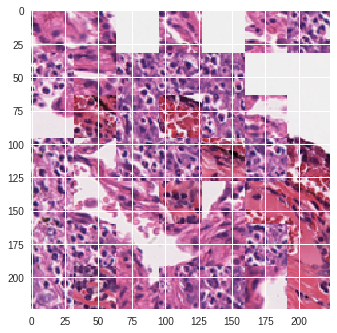

In [ ]:
plt.imshow(triple_images[3])

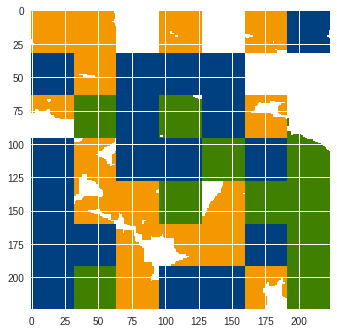

In [ ]:
plt.imshow(triple_image_masks[3])

In [ ]:
prob_grids[3]

[[3, 3, 2, 3, 2, 3, 1],
 [1, 3, 1, 1, 1, 2, 2],
 [3, 2, 1, 2, 1, 3, 2],
 [1, 3, 1, 1, 2, 1, 2],
 [1, 3, 3, 2, 3, 2, 2],
 [1, 1, 3, 3, 3, 1, 2],
 [1, 2, 3, 1, 1, 3, 2]]

In [ ]:
len(triple_images)

400

In [ ]:
len(only_tumour_i)

1181

In [ ]:
len(only_stroma_i)

1680

In [ ]:
len(only_normal_i)

1832

In [ ]:
def create_random_double_map(class_one_value,class_two_value):
  map = []
  for y in range(7):
      row = []
      for x in range(7):
          value = random.randint(1, 2)
          if value==1:
            row.append(class_one_value)
          elif value ==2:
            row.append(class_two_value)
      map.append(row)
  return map 

In [ ]:
def create_double_class_image(class_one_grid, class_two_grid, class_one_mask_grid, class_two_mask_grid, class_one_value,class_two_value):
  prob_grid = create_random_double_map(class_one_value, class_two_value)
  image = np.zeros((224,224,3),dtype=np.uint8)
  mask = np.zeros((224,224,3),dtype=np.uint8)

  if class_one_value == 1:
    class_one_string = 'tumour'
  elif class_one_value == 2:
    class_one_string = 'stroma'
  elif class_one_value == 3:
    class_one_string = 'normal' 

  if class_two_value == 1:
    class_two_string = 'tumour'
  elif class_two_value == 2:
    class_two_string = 'stroma'
  elif class_two_value == 3:
    class_two_string = 'normal'

  for i in range(1,8):
    for j in range(1,8):
      if prob_grid[i-1][j-1] == class_one_value:
        image[(i-1)*32 : i*32, (j-1)*32 : j*32, :] = class_one_grid[i-1][j-1]
        mask[(i-1)*32 : i*32, (j-1)*32 : j*32, :] = class_one_mask_grid[i-1][j-1]

      elif prob_grid[i-1][j-1] == class_two_value:
        image[(i-1)*32:i*32,(j-1)*32:j*32,:] = class_two_grid[i-1][j-1]
        mask[(i-1)*32 : i*32, (j-1)*32 : j*32, :] = class_two_mask_grid[i-1][j-1]

  spare_images = {
      'tumour': list(),
      'stroma': list(),
      'normal': list()
  }
  spare_image_masks = {
      'tumour':list(),
      'stroma':list(),
      'normal':list()
  }

  for i in range(0,7):
    for j in range(0,7):
      if prob_grid[i][j] == class_one_value:

        spare_images[class_two_string].append(class_two_grid[i][j])
        spare_image_masks[class_two_string].append(class_two_mask_grid[i][j])

      elif prob_grid[i][j] == class_two_value:
        spare_images[class_one_string].append(class_one_grid[i][j])
        spare_image_masks[class_one_string].append(class_one_mask_grid[i][j])


  return image, mask, prob_grid, spare_images, spare_image_masks


In [ ]:
image, mask, grid, spare_images_dict, spare_mask_dict = create_double_class_image(tumour_image_grids[401],stroma_image_grids[401], tumour_mask_grids[401], stroma_mask_grids[401], 1 , 2)

In [ ]:
tumour_stroma_images = list()
tumour_stroma_masks = list()
spare_image_tumour_stroma = list()
spare_image_tumour_stroma_masks = list()
prob_grids_tumour_stroma = list()

for i in range(400,1000):
  image, mask, grid, spare_images_dict, spare_mask_dict = create_double_class_image(tumour_image_grids[i],stroma_image_grids[i], tumour_mask_grids[i], stroma_mask_grids[i], 1 , 2)
  tumour_stroma_images.append(image)
  tumour_stroma_masks.append(mask)
  prob_grids.append(grid)
  spare_image_tumour_stroma.append(spare_images_dict)
  spare_image_tumour_stroma_masks.append(spare_mask_dict)


In [ ]:
len(tumour_stroma_images)

600

In [ ]:
normal_tumour_images = list()
normal_tumour_masks = list()
spare_image_normal_tumour = list()
spare_image_normal_tumour_mask = list()
prob_grids_normal_tumour = list()

for i in range(400,581):
  image, mask, grid, spare_images_dict, spare_mask_dict = create_double_class_image(normal_image_grids[i],tumour_image_grids[i+600], normal_mask_grids[i], tumour_mask_grids[i+600], 3 , 1)
  normal_tumour_images.append(image)
  normal_tumour_masks.append(mask)
  prob_grids_normal_tumour.append(grid)
  spare_image_normal_tumour.append(spare_images_dict)
  spare_image_normal_tumour_mask.append(spare_mask_dict)

In [ ]:
len(normal_tumour_images)

181

In [ ]:
normal_stroma_images = list()
normal_stroma_masks = list()
spare_image_normal_stroma = list()
spare_image_normal_stroma_mask = list()
prob_grids_normal_stroma = list()

for i in range(1000,1680):
  image, mask, grid, spare_images_dict, spare_mask_dict = create_double_class_image(normal_image_grids[i-419],stroma_image_grids[i], normal_mask_grids[i-419], stroma_mask_grids[i], 3 , 2)
  normal_stroma_images.append(image)
  normal_stroma_masks.append(mask)
  prob_grids.append(grid)
  spare_image_normal_stroma.append(spare_images_dict)
  spare_image_normal_stroma_mask.append(spare_mask_dict)


In [ ]:
len(normal_stroma_images)

680

In [ ]:
len(only_stroma_i)

1680

In [ ]:
len(spare_image_normal_tumour)

181

In [ ]:
# Append spares

spare_tumour_patches = list()
spare_tumour_mask_patches = list()

spare_stroma_patches = list()
spare_stroma_mask_patches = list()

spare_normal_patches = list()
spare_normal_mask_patches = list()



In [ ]:
def spare_image_collector(image_dict_list, mask_dict_list):
  for i in range(len(image_dict_list)):
    spare_tumour_patches.extend(image_dict_list[i]['tumour'])
    spare_tumour_mask_patches.extend(mask_dict_list[i]['tumour'])

    spare_stroma_patches.extend(image_dict_list[i]['stroma'])
    spare_stroma_mask_patches.extend(mask_dict_list[i]['stroma'])

    spare_normal_patches.extend(image_dict_list[i]['normal'])
    spare_normal_mask_patches.extend(mask_dict_list[i]['normal'])



In [ ]:
spare_image_collector(spare_images_triple,spare_image_masks_triple)
spare_image_collector(spare_image_tumour_stroma, spare_image_tumour_stroma_masks)
spare_image_collector(spare_image_normal_stroma, spare_image_normal_stroma_mask)
spare_image_collector(spare_image_normal_tumour, spare_image_normal_tumour_mask)

In [ ]:
len(spare_tumour_patches)

25872

In [ ]:
len(spare_stroma_patches)

44269

In [ ]:
len(spare_normal_patches)

40648

## Create More Random Spares

In [ ]:
def create_random_spare_triple(patch_stats,number_of_images):
  tumour_used = patch_stats[0]
  stroma_used = patch_stats[1]
  normal_used = patch_stats[2]
  images = list()
  masks = list()

  for i in range(number_of_images):
    prob_grid = create_random_triple_map()
    image = np.zeros((224,224,3),dtype=np.uint8)
    mask = np.zeros((224,224,3),dtype=np.uint8)
    

    for i in range(1,8):
      for j in range(1,8):
        if prob_grid[i-1][j-1] == 1:
          image[(i-1)*32 : i*32, (j-1)*32 : j*32, :] = spare_tumour_patches[tumour_used]
          mask[(i-1)*32 : i*32, (j-1)*32 : j*32, :] = spare_tumour_mask_patches[tumour_used]
          tumour_used +=1 
        elif prob_grid[i-1][j-1] == 2:
          image[(i-1)*32:i*32,(j-1)*32:j*32,:] = spare_stroma_patches[stroma_used]
          mask[(i-1)*32 : i*32, (j-1)*32 : j*32, :] = spare_stroma_mask_patches[stroma_used]
          stroma_used+=1

        elif prob_grid[i-1][j-1] == 3:
          image[(i-1)*32:i*32,(j-1)*32:j*32,:] = spare_normal_patches[normal_used]
          mask[(i-1)*32 : i*32, (j-1)*32 : j*32, :] = spare_normal_mask_patches[normal_used]
          normal_used+=1
    images.append(image)
    masks.append(mask)


  image_stats = [tumour_used,stroma_used,normal_used]


  return images,masks, image_stats



In [ ]:
stats = [0,0,0]
r_triple_images, r_triple_masks, new_stats = create_random_spare_triple(stats,800)

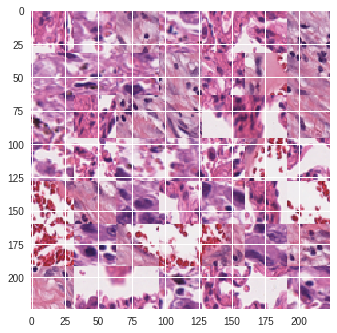

In [ ]:
plt.imshow(r_triple_images[0])

In [ ]:
new_stats

[13131, 13003, 13066]

In [ ]:
def create_random_spare_double(patch_stats,number_of_images,class_one_value, class_two_value):
  tumour_used = patch_stats[0]
  stroma_used = patch_stats[1]
  normal_used = patch_stats[2]
  images = list()
  masks = list()

  for i in range(number_of_images):
    prob_grid = create_random_double_map(class_one_value,class_two_value)
    image = np.zeros((224,224,3),dtype=np.uint8)
    mask = np.zeros((224,224,3),dtype=np.uint8)
    

    for i in range(1,8):
      for j in range(1,8):
        if prob_grid[i-1][j-1] == 1:
          image[(i-1)*32 : i*32, (j-1)*32 : j*32, :] = spare_tumour_patches[tumour_used]
          mask[(i-1)*32 : i*32, (j-1)*32 : j*32, :] = spare_tumour_mask_patches[tumour_used]
          tumour_used +=1 
        elif prob_grid[i-1][j-1] == 2:
          image[(i-1)*32:i*32,(j-1)*32:j*32,:] = spare_stroma_patches[stroma_used]
          mask[(i-1)*32 : i*32, (j-1)*32 : j*32, :] = spare_stroma_mask_patches[stroma_used]
          stroma_used+=1

        elif prob_grid[i-1][j-1] == 3:
          image[(i-1)*32:i*32,(j-1)*32:j*32,:] = spare_normal_patches[normal_used]
          mask[(i-1)*32 : i*32, (j-1)*32 : j*32, :] = spare_normal_mask_patches[normal_used]
          normal_used+=1
    images.append(image)
    masks.append(mask)


  image_stats = [tumour_used,stroma_used,normal_used]


  return images,masks, image_stats



In [ ]:
r_ts_images, r_ts_masks, new_stats = create_random_spare_double(new_stats,500,1,2)

In [ ]:
r_ns_images, r_ns_masks, new_stats = create_random_spare_double(new_stats,600,2,3)

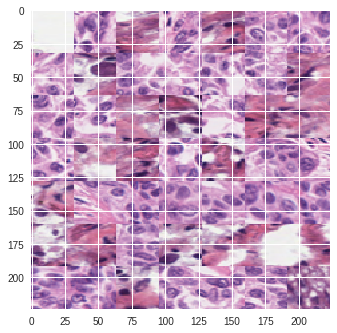

In [ ]:
plt.imshow(r_ts_images[0])

In [ ]:
type(r_ts_images[0])

numpy.ndarray

In [ ]:
training_X = list()
training_y = list()


In [ ]:
training_X.extend(triple_images)
training_X.extend(tumour_stroma_images)
training_X.extend(normal_tumour_images)
training_X.extend(normal_stroma_images)
training_X.extend(r_triple_images)
training_X.extend(r_ts_images)
training_X.extend(r_ns_images)

In [ ]:
training_y.extend(triple_image_masks)
training_y.extend(tumour_stroma_masks)
training_y.extend(normal_tumour_masks)
training_y.extend(normal_stroma_masks)
training_y.extend(r_triple_masks)
training_y.extend(r_ts_masks)
training_y.extend(r_ns_masks)

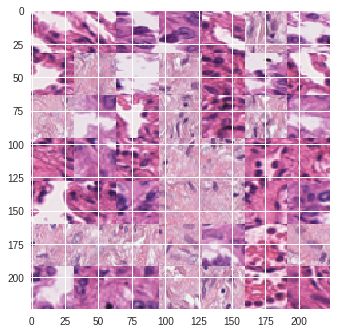

In [ ]:
plt.imshow(training_X[2000])

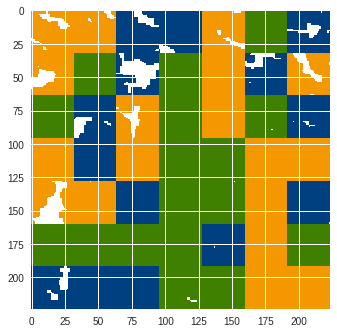

In [ ]:
plt.imshow(training_y[2000])

In [ ]:
len(training_y)

3761

In [ ]:
for i in range(len(training_X)):
  number = str(i)
  with open('/content/gdrive/MyDrive/Train_full_grid_3/images/'+number+'.npy', 'wb') as f:
      np.save(f, training_X[i])

  with open('/content/gdrive/MyDrive/Train_full_grid_3/masks/'+number+'.npy', 'wb') as f:
      np.save(f, training_y[i])

